 Create Mixed Dataset

In [1]:
import pandas as pd
import numpy as np

# Fixed latitude and longitude for Hyderabad
latitude = 17.3850
longitude = 78.4867

# Generate synthetic data
num_samples = 2000
synthetic_data = []

for _ in range(num_samples):
    depth = np.random.choice(["0-5 cm", "5-15 cm", "15-30 cm", "30-60 cm"])
    # Randomize conditions
    is_optimal = np.random.choice([True, False])

    if is_optimal:
        # Optimal conditions
        nitrogen = np.random.uniform(0.2, 0.5)  # g/kg
        phosphorus = np.random.uniform(5, 30)  # mg/kg
        potassium = np.random.uniform(0.5, 1.5)  # cmol/kg
        ph = np.random.uniform(5.5, 6.5)  # Ideal pH for rice
        temperature = np.random.uniform(25, 35)  # Ideal temperature range
        humidity = np.random.uniform(70, 90)  # High humidity preferred
        rainfall = np.random.uniform(100, 200)  # Sufficient rainfall
        disease = "Healthy"
    else:
        # Non-optimal conditions (introduce anomalies)
        nitrogen = np.random.uniform(0.05, 0.7)
        phosphorus = np.random.uniform(1, 50)
        potassium = np.random.uniform(0.3, 2)
        ph = np.random.uniform(4, 9)
        temperature = np.random.uniform(15, 45)
        humidity = np.random.uniform(50, 100)
        rainfall = np.random.uniform(50, 300)

        # Assign diseases based on conditions
        if humidity > 85 and temperature > 30:
            disease = "Blast"
        elif nitrogen > 0.5 and ph < 6:
            disease = "Sheath Blight"
        else:
            disease = "Suboptimal Growth"

    synthetic_data.append({
        "Latitude": latitude,
        "Longitude": longitude,
        "Depth": depth,
        "Nitrogen (g/kg)": round(nitrogen, 4),
        "Phosphorus (mg/kg)": round(phosphorus, 2),
        "Potassium (cmol/kg)": round(potassium, 4),
        "pH": round(ph, 2),
        "Temperature (°C)": round(temperature, 2),
        "Humidity (%)": round(humidity, 2),
        "Rainfall (mm)": round(rainfall, 2),
        "Disease": disease
    })

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Save the dataset
file_path = r"C:\Users\bhjai\Downloads\mixed_rice_growth_dataset.csv"
synthetic_df.to_csv(file_path, index=False)

print(f"Dataset saved successfully at {file_path}")


Dataset saved successfully at C:\Users\bhjai\Downloads\mixed_rice_growth_dataset.csv


Add Real-Time Data Integration

In [2]:
import requests

def fetch_weather(lat, lon):
    api_key = "b1f167d835524000bd0165053242911"  # Replace with your actual API key
    url = f"https://api.weatherapi.com/v1/current.json?key={api_key}&q={lat},{lon}&aqi=no"
    response = requests.get(url).json()
    
    # Parse weather data
    temperature = response['current']['temp_c']  # Temperature in Celsius
    humidity = response['current']['humidity']   # Humidity in percentage
    rainfall = response.get('current', {}).get('precip_mm', 0)  # Rainfall in mm
    return temperature, humidity, rainfall

# Test for Hyderabad
lat, lon = 17.3850, 78.4867
temperature, humidity, rainfall = fetch_weather(lat, lon)
print(f"Current Conditions: Temperature={temperature}°C, Humidity={humidity}%, Rainfall={rainfall}mm")


Current Conditions: Temperature=24.3°C, Humidity=89%, Rainfall=0.2mm


Add NDVI VALUES TO DATASET

In [3]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\bhjai\Downloads\mixed_rice_growth_dataset.csv"
df = pd.read_csv(file_path)

# Preview the dataset
print("Dataset Loaded:")
print(df.head())


Dataset Loaded:
   Latitude  Longitude     Depth  Nitrogen (g/kg)  Phosphorus (mg/kg)  \
0    17.385    78.4867  15-30 cm           0.0843               35.32   
1    17.385    78.4867   5-15 cm           0.1224               23.78   
2    17.385    78.4867    0-5 cm           0.6445               31.23   
3    17.385    78.4867  15-30 cm           0.6195                9.79   
4    17.385    78.4867  30-60 cm           0.2690               34.71   

   Potassium (cmol/kg)    pH  Temperature (°C)  Humidity (%)  Rainfall (mm)  \
0               0.8717  8.76             36.88         62.54         175.16   
1               1.4859  6.92             22.00         78.84         281.92   
2               0.7248  4.21             25.35         98.16         116.75   
3               0.9398  5.42             19.41         71.78          89.42   
4               1.6555  7.48             19.96         51.00         260.91   

             Disease  
0  Suboptimal Growth  
1  Suboptimal Growth  
2

Fetch NDVI for Each Location

In [6]:
import ee

# Initialize Google Earth Engine
service_account = 'agriculture@agriculture-analysis.iam.gserviceaccount.com'
private_key_path =r'C:\Users\bhjai\Downloads\agriculture-analysis-c09db52519a2.json'
credentials = ee.ServiceAccountCredentials(service_account, private_key_path)
ee.Initialize(credentials)

# Function to fetch NDVI
def fetch_ndvi(lat, lon, start_date='2023-01-01', end_date='2023-12-31'):
    try:
        roi = ee.Geometry.Point([lon, lat])
        
        # Fetch Sentinel-2 data
        dataset = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
            .filterBounds(roi) \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
        
        # Compute NDVI
        ndvi_image = dataset.median().normalizedDifference(['B8', 'B4'])
        ndvi = ndvi_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=10
        ).getInfo()

        return ndvi.get('nd', None)
    except Exception as e:
        print(f"Error fetching NDVI for location ({lat}, {lon}): {e}")
        return None


Add NDVI to Each Row

In [9]:
# Extract unique Latitude and Longitude pairs
coordinates = df[['Latitude', 'Longitude']].drop_duplicates()
print(coordinates.head())


   Latitude  Longitude
0    17.385    78.4867


Fetch NDVI in Bulk

In [12]:
import ee

# Initialize Earth Engine
service_account = 'agriculture@agriculture-analysis.iam.gserviceaccount.com'
private_key_path = r'C:\Users\bhjai\Downloads\agriculture-analysis-c09db52519a2.json'
credentials = ee.ServiceAccountCredentials(service_account, private_key_path)
ee.Initialize(credentials)

# Define Hyderabad region as a bounding box
hyderabad_region = ee.Geometry.Rectangle([78.3405, 17.1940, 78.6291, 17.5041])  # Adjust as needed


 Fetch NDVI Data for Hyderabad

In [15]:
def fetch_ndvi_hyderabad(start_date='2023-01-01', end_date='2023-12-31'):
    try:
        # Filter Sentinel-2 dataset for Hyderabad region
        dataset = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
            .filterBounds(hyderabad_region) \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
        
        # Calculate NDVI
        ndvi_image = dataset.median().normalizedDifference(['B8', 'B4'])
        
        # Reduce NDVI data to a single value per region
        ndvi_stats = ndvi_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=hyderabad_region,
            scale=500,  # Coarser scale (500 meters)
            maxPixels=1e8,  # Increase max pixels limit
            bestEffort=True  # Allow aggregation with reduced precision
        ).getInfo()
        
        return ndvi_stats.get('nd', None)
    except Exception as e:
        print(f"Error fetching NDVI for Hyderabad: {e}")
        return None

# Fetch NDVI for Hyderabad
ndvi_hyderabad = fetch_ndvi_hyderabad()
print(f"NDVI for Hyderabad: {ndvi_hyderabad}")


NDVI for Hyderabad: 0.2007114866387348


Add NDVI to Your Dataset

In [16]:
# Add NDVI to the dataset
df['NDVI'] = ndvi_hyderabad

# Save the updated dataset
updated_file_path = r"C:\Users\bhjai\Downloads\mixed_rice_growth_dataset_with_ndvi.csv"
df.to_csv(updated_file_path, index=False)

print(f"Updated dataset saved successfully at {updated_file_path}")


Updated dataset saved successfully at C:\Users\bhjai\Downloads\mixed_rice_growth_dataset_with_ndvi.csv


In [17]:
print("Updated Dataset Preview:")
print(df.head())


Updated Dataset Preview:
   Latitude  Longitude     Depth  Nitrogen (g/kg)  Phosphorus (mg/kg)  \
0    17.385    78.4867  15-30 cm           0.0843               35.32   
1    17.385    78.4867   5-15 cm           0.1224               23.78   
2    17.385    78.4867    0-5 cm           0.6445               31.23   
3    17.385    78.4867  15-30 cm           0.6195                9.79   
4    17.385    78.4867  30-60 cm           0.2690               34.71   

   Potassium (cmol/kg)    pH  Temperature (°C)  Humidity (%)  Rainfall (mm)  \
0               0.8717  8.76             36.88         62.54         175.16   
1               1.4859  6.92             22.00         78.84         281.92   
2               0.7248  4.21             25.35         98.16         116.75   
3               0.9398  5.42             19.41         71.78          89.42   
4               1.6555  7.48             19.96         51.00         260.91   

             Disease      NDVI  
0  Suboptimal Growth  0.2007

TRAINING ML MODEL

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the dataset
file_path = r"C:\Users\bhjai\Downloads\mixed_rice_growth_dataset_with_ndvi.csv"
df = pd.read_csv(file_path)


# Prepare features (X) and target (y)
X = df[['Nitrogen (g/kg)', 'Phosphorus (mg/kg)', 'Potassium (cmol/kg)', 'pH',
        'Temperature (°C)', 'Humidity (%)', 'Rainfall (mm)', 'NDVI']]
y = df['Disease']  # Target column with labels like 'Healthy', 'Blast', etc.

# Encode the target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert labels to integers

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Neural Network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_scaled).argmax(axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Epoch 1/50


c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4305 - loss: 1.2266 - val_accuracy: 0.7563 - val_loss: 0.8204
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7281 - loss: 0.8241 - val_accuracy: 0.7906 - val_loss: 0.6529
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7763 - loss: 0.7029 - val_accuracy: 0.8406 - val_loss: 0.5458
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8550 - loss: 0.5085 - val_accuracy: 0.8562 - val_loss: 0.4431
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8635 - loss: 0.4599 - val_accuracy: 0.8781 - val_loss: 0.3653
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9042 - loss: 0.3743 - val_accuracy: 0.9000 - val_loss: 0.3062
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9157 - loss: 0.3126 - val_accuracy: 0.9062 - val_loss: 0.2613
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8889 - loss: 0.3264 - val_accuracy: 0.9281 - val_loss: 0.2288
Epo

Verify Predictions with Real-Time Data

In [22]:
def predict_rice_condition(**kwargs):
    # Ensure all required features are present
    required_features = ['Nitrogen (g/kg)', 'Phosphorus (mg/kg)', 'Potassium (cmol/kg)', 
                         'pH', 'Temperature (°C)', 'Humidity (%)', 'Rainfall (mm)', 'NDVI']
    input_data = np.array([[kwargs[feature] for feature in required_features]])
    input_scaled = scaler.transform(input_data)  # Scale the input
    prediction = model.predict(input_scaled).argmax(axis=1)
    predicted_label = label_encoder.inverse_transform(prediction)
    return predicted_label[0]

# Test with real-time data
real_time_input = {
    "Nitrogen (g/kg)": 0.3,
    "Phosphorus (mg/kg)": 20,
    "Potassium (cmol/kg)": 1.5,
    "pH": 6.5,
    "Temperature (°C)": 28,
    "Humidity (%)": 85,
    "Rainfall (mm)": 50,
    "NDVI": 0.6
}

predicted_condition = predict_rice_condition(**real_time_input)
print(f"Predicted Condition: {predicted_condition}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Condition: Suboptimal Growth


c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1.Evaluate Model Performance

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
Classification Report:
                   precision    recall  f1-score   support

            Blast       0.94      0.88      0.91        34
          Healthy       0.99      1.00      0.99       186
    Sheath Blight       0.81      0.71      0.76        24
Suboptimal Growth       0.94      0.96      0.95       156

         accuracy                           0.96       400
        macro avg       0.92      0.89      0.90       400
     weighted avg       0.96      0.96      0.96       400



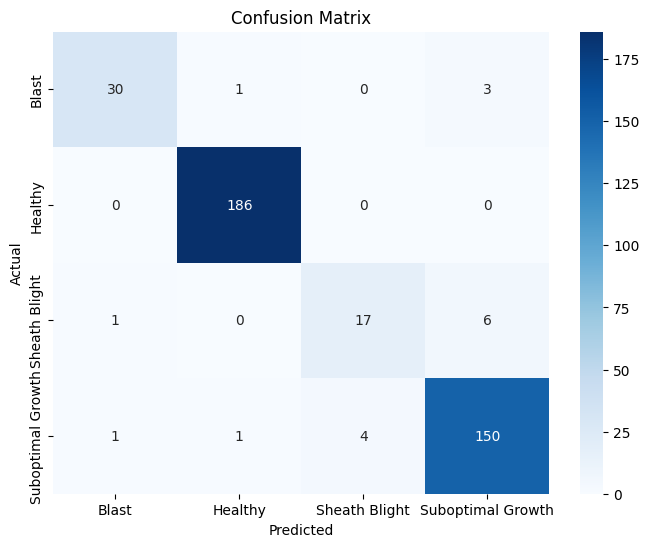

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on test set
y_pred = model.predict(X_test_scaled).argmax(axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


2.Perform Cross-Validation

In [27]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

# Define the model creation function
def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model using KerasClassifier
keras_model = KerasClassifier(model=create_model, epochs=50, batch_size=32, verbose=0)

# Perform cross-validation
cv_scores = cross_val_score(keras_model, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))


c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in

Cross-Validation Scores: [0.9625   0.953125 0.96875  0.971875 0.95    ]
Mean Accuracy: 0.96125


3 Test with Real-Time Data

In [28]:
# Example real-time inputs for testing
real_time_inputs = [
    {"Nitrogen (g/kg)": 0.3, "Phosphorus (mg/kg)": 20, "Potassium (cmol/kg)": 1.5, "pH": 6.5, "Temperature (°C)": 28, "Humidity (%)": 85, "Rainfall (mm)": 50, "NDVI": 0.6},
    {"Nitrogen (g/kg)": 0.15, "Phosphorus (mg/kg)": 15, "Potassium (cmol/kg)": 1.2, "pH": 5.5, "Temperature (°C)": 30, "Humidity (%)": 90, "Rainfall (mm)": 70, "NDVI": 0.5}
]

for input_data in real_time_inputs:
    condition = predict_rice_condition(**input_data)
    print(f"Predicted Condition for input {input_data}: {condition}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Condition for input {'Nitrogen (g/kg)': 0.3, 'Phosphorus (mg/kg)': 20, 'Potassium (cmol/kg)': 1.5, 'pH': 6.5, 'Temperature (°C)': 28, 'Humidity (%)': 85, 'Rainfall (mm)': 50, 'NDVI': 0.6}: Suboptimal Growth
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Condition for input {'Nitrogen (g/kg)': 0.15, 'Phosphorus (mg/kg)': 15, 'Potassium (cmol/kg)': 1.2, 'pH': 5.5, 'Temperature (°C)': 30, 'Humidity (%)': 90, 'Rainfall (mm)': 70, 'NDVI': 0.5}: Suboptimal Growth


c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 Test Non-Optimal Conditions

In [39]:
# Define test cases for non-optimal conditions
test_cases = [
    {"Nitrogen (g/kg)": 0.1, "Phosphorus (mg/kg)": 5, "Potassium (cmol/kg)": 0.4, "pH": 4.0, "Temperature (°C)": 18, "Humidity (%)": 40, "Rainfall (mm)": 40, "NDVI": 0.2},
    {"Nitrogen (g/kg)": 0.5, "Phosphorus (mg/kg)": 50, "Potassium (cmol/kg)": 2.5, "pH": 8.5, "Temperature (°C)": 42, "Humidity (%)": 95, "Rainfall (mm)": 350, "NDVI": 0.9},
    {"Nitrogen (g/kg)": 0.2, "Phosphorus (mg/kg)": 20, "Potassium (cmol/kg)": 1.0, "pH": 6.0, "Temperature (°C)": 30, "Humidity (%)": 80, "Rainfall (mm)": 150, "NDVI": 0.6},
    {"Nitrogen (g/kg)": 0.15, "Phosphorus (mg/kg)": 8, "Potassium (cmol/kg)": 0.8, "pH": 5.0, "Temperature (°C)": 25, "Humidity (%)": 60, "Rainfall (mm)": 70, "NDVI": 0.4},
    {"Nitrogen (g/kg)": 0.05, "Phosphorus (mg/kg)": 4, "Potassium (cmol/kg)": 0.5, "pH": 4.5, "Temperature (°C)": 22, "Humidity (%)": 70, "Rainfall (mm)": 60, "NDVI": 0.3},
    
]

# Test the model with these conditions
for i, case in enumerate(test_cases, start=1):
    condition = predict_rice_condition(**case)
    print(f"Test Case {i}: {case}")
    print(f"Predicted Condition: {condition}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Test Case 1: {'Nitrogen (g/kg)': 0.1, 'Phosphorus (mg/kg)': 5, 'Potassium (cmol/kg)': 0.4, 'pH': 4.0, 'Temperature (°C)': 18, 'Humidity (%)': 40, 'Rainfall (mm)': 40, 'NDVI': 0.2}
Predicted Condition: Suboptimal Growth
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Test Case 2: {'Nitrogen (g/kg)': 0.5, 'Phosphorus (mg/kg)': 50, 'Potassium (cmol/kg)': 2.5, 'pH': 8.5, 'Temperature (°C)': 42, 'Humidity (%)': 95, 'Rainfall (mm)': 350, 'NDVI': 0.9}
Predicted Condition: Blast
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Test Case 3: {'Nitrogen (g/kg)': 0.2, 'Phosphorus (mg/kg)': 20, 'Potassium (cmol/kg)': 1.0, 'pH': 6.0, 'Temperature (°C)': 30, 'Humidity (%)': 80, 'Rainfall (mm)': 150, 'NDVI': 0.6}
Predicted Condition: Healthy
--------------------------------------------------


c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Test Case 4: {'Nitrogen (g/kg)': 0.15, 'Phosphorus (mg/kg)': 8, 'Potassium (cmol/kg)': 0.8, 'pH': 5.0, 'Temperature (°C)': 25, 'Humidity (%)': 60, 'Rainfall (mm)': 70, 'NDVI': 0.4}
Predicted Condition: Suboptimal Growth
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Test Case 5: {'Nitrogen (g/kg)': 0.05, 'Phosphorus (mg/kg)': 4, 'Potassium (cmol/kg)': 0.5, 'pH': 4.5, 'Temperature (°C)': 22, 'Humidity (%)': 70, 'Rainfall (mm)': 60, 'NDVI': 0.3}
Predicted Condition: Suboptimal Growth
--------------------------------------------------


c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Code for Tabular Output

In [41]:
import pandas as pd

# Define test cases for non-optimal conditions
test_cases = [
    {"Nitrogen (g/kg)": 0.1, "Phosphorus (mg/kg)": 5, "Potassium (cmol/kg)": 0.4, "pH": 4.0, "Temperature (°C)": 18, "Humidity (%)": 40, "Rainfall (mm)": 40, "NDVI": 0.2},
    {"Nitrogen (g/kg)": 0.5, "Phosphorus (mg/kg)": 50, "Potassium (cmol/kg)": 2.5, "pH": 8.5, "Temperature (°C)": 42, "Humidity (%)": 95, "Rainfall (mm)": 350, "NDVI": 0.9},
    {"Nitrogen (g/kg)": 0.2, "Phosphorus (mg/kg)": 20, "Potassium (cmol/kg)": 1.0, "pH": 6.0, "Temperature (°C)": 30, "Humidity (%)": 80, "Rainfall (mm)": 150, "NDVI": 0.6},
    {"Nitrogen (g/kg)": 0.15, "Phosphorus (mg/kg)": 8, "Potassium (cmol/kg)": 0.8, "pH": 5.0, "Temperature (°C)": 25, "Humidity (%)": 60, "Rainfall (mm)": 70, "NDVI": 0.4},
    {"Nitrogen (g/kg)": 0.05, "Phosphorus (mg/kg)": 4, "Potassium (cmol/kg)": 0.5, "pH": 4.5, "Temperature (°C)": 22, "Humidity (%)": 70, "Rainfall (mm)": 60, "NDVI": 0.3},
    
]


# Initialize a list to store results
results = []

# Predict conditions for each test case
for i, case in enumerate(test_cases, start=1):
    predicted_condition = predict_rice_condition(**case)
    case["Predicted Condition"] = predicted_condition  # Add prediction to the case
    results.append(case)

# Convert results to a DataFrame for tabular display
results_df = pd.DataFrame(results)

# Display the DataFrame in Jupyter Notebook
from IPython.display import display
display(results_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\bhjai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,Nitrogen (g/kg),Phosphorus (mg/kg),Potassium (cmol/kg),pH,Temperature (°C),Humidity (%),Rainfall (mm),NDVI,Predicted Condition
0,0.10,5,0.4,4.0,18,40,40,0.2,Suboptimal Growth
1,0.50,50,2.5,8.5,42,95,350,0.9,Blast
2,0.20,20,1.0,6.0,30,80,150,0.6,Healthy
3,0.15,8,0.8,5.0,25,60,70,0.4,Suboptimal Growth
4,0.05,4,0.5,4.5,22,70,60,0.3,Suboptimal Growth


1. Save the Model

In [42]:
model_path = r"C:\Users\bhjai\Downloads\rice_growth_model.h5"
model.save(model_path)
print(f"Model saved at {model_path}")


Model saved at C:\Users\bhjai\Downloads\rice_growth_model.h5


Save the Scaler and Label Encoder

In [43]:
import pickle

# Save the scaler
scaler_path = r"C:\Users\bhjai\Downloads\rice_growth_scaler.pkl"
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)
print(f"Scaler saved at {scaler_path}")

# Save the label encoder
label_encoder_path = r"C:\Users\bhjai\Downloads\rice_growth_label_encoder.pkl"
with open(label_encoder_path, 'wb') as file:
    pickle.dump(label_encoder, file)
print(f"Label Encoder saved at {label_encoder_path}")


Scaler saved at C:\Users\bhjai\Downloads\rice_growth_scaler.pkl
Label Encoder saved at C:\Users\bhjai\Downloads\rice_growth_label_encoder.pkl


In [4]:
!pipreqs . --force


INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in .\requirements.txt
